In [31]:
import requests

def fetch_categories():
    url = "https://api.coingecko.com/api/v3/coins/categories/list"
    response = requests.get(url)
    categories = response.json()
    return categories

categories = fetch_categories()
print(categories)

[{'category_id': 'aave-tokens', 'name': 'Aave Tokens'}, {'category_id': 'account-abstraction', 'name': 'Account Abstraction'}, {'category_id': 'adidas-ecosystem', 'name': 'Adidas Ecosystem'}, {'category_id': 'adventure-games', 'name': 'Adventure Games'}, {'category_id': 'ai-meme-coins', 'name': 'AI Meme Coins'}, {'category_id': 'alephium-ecosystem', 'name': 'Alephium Ecosystem'}, {'category_id': 'algorand-ecosystem', 'name': 'Algorand Ecosystem'}, {'category_id': 'alleged-sec-securities', 'name': 'Alleged SEC Securities'}, {'category_id': 'analytics', 'name': 'Analytics'}, {'category_id': 'animal-racing', 'name': 'Animal Racing'}, {'category_id': 'animoca-brands', 'name': 'Animoca Brands'}, {'category_id': 'apex-chain-ecosystem', 'name': 'Apex Chain Ecosystem'}, {'category_id': 'aptos-ecosystem', 'name': 'Aptos Ecosystem'}, {'category_id': 'arbitrum-ecosystem', 'name': 'Arbitrum Ecosystem'}, {'category_id': 'arbitrum-nova-ecosystem', 'name': 'Arbitrum Nova Ecosystem'}, {'category_id': 

In [32]:
from pathlib import Path
from pycoingecko import CoinGeckoAPI
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt

In [33]:
def fetch_data(category_id="artificial-intelligence", days="max", interval="daily", base_dir="../../database/API/Coingecko"):
    cg = CoinGeckoAPI()
    base_dir = Path(base_dir).resolve()
    base_dir.mkdir(parents=True, exist_ok=True)

    # Récupérer les cryptomonnaies de la catégorie spécifiée par l'ID
    coins_in_category = cg.get_coins_markets(vs_currency='usd', category=category_id)

    for coin in coins_in_category:
        coin_id = coin['id']
        print(f"Téléchargement des données pour {coin_id}.")
        market_data = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency='usd', days=days, interval=interval)
        prices = market_data['prices']
        df = pd.DataFrame(prices, columns=['timestamp', coin_id])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        cache_path = base_dir / f"{coin_id}_{days}_{interval}.csv"
        df.to_csv(cache_path)

In [34]:
fetch_data(category_id="artificial-intelligence")

Téléchargement des données pour bittensor.
Téléchargement des données pour render-token.
Téléchargement des données pour fetch-ai.
Téléchargement des données pour singularitynet.
Téléchargement des données pour corgiai.
Téléchargement des données pour akash-network.
Téléchargement des données pour ocean-protocol.
Téléchargement des données pour golem.
Téléchargement des données pour arkham.
Téléchargement des données pour origintrail.
Téléchargement des données pour nosana.
Téléchargement des données pour paal-ai.
Téléchargement des données pour 0x0-ai-ai-smart-contract.
Téléchargement des données pour aioz-network.
Téléchargement des données pour iexec-rlc.
Téléchargement des données pour covalent.
Téléchargement des données pour oraichain-token.
Téléchargement des données pour autonolas.
Téléchargement des données pour numeraire.
Téléchargement des données pour humans-ai.
Téléchargement des données pour sleepless-ai.
Téléchargement des données pour agoras-currency-of-tau.
Téléchargem

In [65]:
class MADStrategy:
    def __init__(self, base_dir="../../database/API/Coingecko"):
        self.base_dir = Path(base_dir).resolve()
        self.dataframes = {}
        self.wallet_history = []

    def load_data(self, coin_ids, days="max", interval="daily"):
        for coin_id in coin_ids:
            cache_path = self.base_dir / f"{coin_id}_{days}_{interval}.csv"
            if cache_path.exists():
                df = pd.read_csv(cache_path, index_col='timestamp', parse_dates=True)
                self.dataframes[coin_id] = df

    def calculate_ema_and_mad(self, periods=[21, 200]):
        mad_scores = {}
        for coin, df in self.dataframes.items():
            for period in periods:
                ema_key = f"EMA_{period}"
                df[ema_key] = ta.trend.ema_indicator(close=df[coin], window=period)
            df['MAD'] = df[f'EMA_{periods[0]}'] / df[f'EMA_{periods[1]}']
            self.dataframes[coin] = df
            # Enregistrer la dernière valeur de MAD, si elle n'est pas nan
            if not pd.isna(df['MAD'].iloc[-1]):
                mad_scores[coin] = df['MAD'].iloc[-1]

        # Trier les scores MAD et sélectionner le top 10, en excluant les valeurs nan
        top_mad_coins = sorted(mad_scores.items(), key=lambda x: x[1], reverse=True)[:10]
        return top_mad_coins
    
    def run_backtest(self, start_date, end_date, initial_capital=10000):
        self.capital = initial_capital
        self.portfolio = {}
        portfolio_value_history = []

        for current_date in pd.date_range(start=start_date, end=end_date):
            str_date = current_date.strftime('%Y-%m-%d')
            prepared_dataframes = {}
            for coin, df in self.dataframes.items():
                if str_date in df.index and 'close' in df.columns:
                    prepared_df = df.loc[:str_date, ['close']].copy()
                    prepared_df.rename(columns={'close': coin}, inplace=True)  # Renommer la colonne 'close' avec l'identifiant de la cryptomonnaie
                    prepared_dataframes[coin] = prepared_df

            if not prepared_dataframes:
                print(f"Aucune donnée disponible pour la date {str_date}.")
                continue

            # Calculer le MAD et obtenir le top 10 pour les cryptomonnaies disponibles
            top_mad_coins = self.calculate_ema_and_mad(prepared_dataframes)

            if not top_mad_coins:
                print(f"Aucun top MAD coins trouvé pour la date {str_date}.")
                continue

            coins_to_sell = set(self.portfolio.keys()) - set(coin for coin, _ in top_mad_coins)
            for coin in coins_to_sell:
                self.capital += self.portfolio[coin] * available_dataframes[coin].loc[str_date][coin]  # Correction ici
                del self.portfolio[coin]

            allocation_per_coin = self.capital / len(top_mad_coins)  # Allocation pour chaque crypto
            for coin, _ in top_mad_coins:
                if coin in self.portfolio:
                    continue
                buy_price = available_dataframes[coin].loc[str_date][coin]  # Correction ici
                self.portfolio[coin] = allocation_per_coin / buy_price

            portfolio_value = sum(available_dataframes[coin].loc[str_date][coin] * quantity for coin, quantity in self.portfolio.items()) + self.capital
            portfolio_value_history.append((current_date, portfolio_value))

        portfolio_value_df = pd.DataFrame(portfolio_value_history, columns=['Date', 'Portfolio Value'])
        portfolio_value_df.set_index('Date', inplace=True)
        return portfolio_value_df



In [58]:
from pathlib import Path

# Instanciation de la classe MADStrategy
strategy = MADStrategy()

data_dir = Path("../../database/API/Coingecko").resolve()
coin_ids = [f.stem.split('_')[0] for f in data_dir.glob("*.csv")]
strategy.load_data(coin_ids)

# Calcul du MAD et récupération du top 10
top_mad_coins = strategy.calculate_ema_and_mad()

# Affichage des résultats
print("Top 10 Cryptocurrencies by MAD Ratio:")
for coin, mad_ratio in top_mad_coins:
    print(f"{coin}: MAD Ratio = {mad_ratio}")

Top 10 Cryptocurrencies by MAD Ratio:
deepfakeai: MAD Ratio = 4.462616388579413
synesis-one: MAD Ratio = 3.6503140042008244
quick-intel: MAD Ratio = 3.3369691747956987
noisegpt: MAD Ratio = 3.264204075214636
nosana: MAD Ratio = 3.218870409350436
graphlinq-protocol: MAD Ratio = 2.731261301798203
paal-ai: MAD Ratio = 2.592570717784251
purefi: MAD Ratio = 2.5773725121550575
arkham: MAD Ratio = 2.4326870276026664
delysium: MAD Ratio = 2.419023540757442


Aucune donnée disponible pour la date 2022-01-01.
Aucune donnée disponible pour la date 2022-01-02.
Aucune donnée disponible pour la date 2022-01-03.
Aucune donnée disponible pour la date 2022-01-04.
Aucune donnée disponible pour la date 2022-01-05.
Aucune donnée disponible pour la date 2022-01-06.
Aucune donnée disponible pour la date 2022-01-07.
Aucune donnée disponible pour la date 2022-01-08.
Aucune donnée disponible pour la date 2022-01-09.
Aucune donnée disponible pour la date 2022-01-10.
Aucune donnée disponible pour la date 2022-01-11.
Aucune donnée disponible pour la date 2022-01-12.
Aucune donnée disponible pour la date 2022-01-13.
Aucune donnée disponible pour la date 2022-01-14.
Aucune donnée disponible pour la date 2022-01-15.
Aucune donnée disponible pour la date 2022-01-16.
Aucune donnée disponible pour la date 2022-01-17.
Aucune donnée disponible pour la date 2022-01-18.
Aucune donnée disponible pour la date 2022-01-19.
Aucune donnée disponible pour la date 2022-01-20.


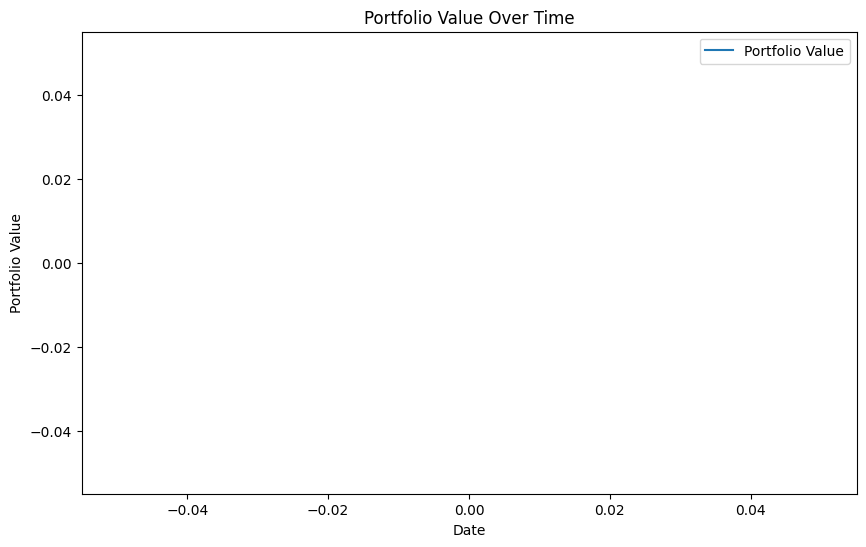

In [66]:
import matplotlib.pyplot as plt

strategy = MADStrategy()
data_dir = Path("../../database/API/Coingecko").resolve()
coin_ids = [f.stem.split('_')[0] for f in data_dir.glob("*.csv")]
strategy.load_data(coin_ids)  # Chargez les données comme avant
portfolio_value_df = strategy.run_backtest('2022-01-01', '2024-02-02')

plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_df.index, portfolio_value_df['Portfolio Value'], label='Portfolio Value')  # Modifiez 'Value' par 'Portfolio Value'
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()